# Common Voice Analysis
This notebook analyzes the `train.tsv` split from the [Mozilla Common Voice 13.0](https://huggingface.co/datasets/mozilla-foundation/common_voice_13_0) dataset using pandas and seaborn.  
The goal is to understand speaker demographics and sentence structure to inform future work on dialect-aware TTS models.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.figure(figsize=(12, 8))

TRAIN_FILE_PATH = "./data/train.tsv"

assert os.path.exists(TRAIN_FILE_PATH), f"File not found: {TRAIN_FILE_PATH}"

<Figure size 1200x800 with 0 Axes>

### Loading Data
The `train` split is used because it contains the majority of the data and gives a better view of demographic distributions, accent diversity, and sentence variability.

In [2]:
def load_data(file_path: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(file_path, sep="\t")
        print(f"Data loaded successfully from {file_path}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()


df = load_data(TRAIN_FILE_PATH)
df.head()

Data loaded successfully from ./data/train.tsv


,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,09cf128e35eee9b49f71a4c58d893f1a5131b504747470...,common_voice_en_21635524.mp3,This device has a cathode inside an anode wire...,2,0,NaN,NaN,NaN,NaN,en,NaN
1,09cf128e35eee9b49f71a4c58d893f1a5131b504747470...,common_voice_en_21635525.mp3,This product is almost always produced by the ...,2,0,NaN,NaN,NaN,NaN,en,NaN
2,09cf128e35eee9b49f71a4c58d893f1a5131b504747470...,common_voice_en_21635526.mp3,It is named after Edward Singleton Holden.,2,0,NaN,NaN,NaN,NaN,en,NaN
3,09cf128e35eee9b49f71a4c58d893f1a5131b504747470...,common_voice_en_21635527.mp3,It is north west of the regional centre of Clare.,2,0,NaN,NaN,NaN,NaN,en,NaN
4,09d2e23c85b125c9825ea8da0159cfa8fe602194f602a2...,common_voice_en_28821136.mp3,He was a nephew of Rear-Admiral Sir Francis Au...,2,0,twenties,female,United States English,NaN,en,NaN


## Drop Unused Columns
The `train.tsv` file is structured as follows:

`client_id | path | sentence | up_votes | down_votes | age | gender | accents | variant | locale | segment`

For the purposes of this analysis, we will only use the following columns and drop the rest: <br>
`sentence | age | gender | accents`

where `sentence` is the transcipt spoken by the individual in their audio file, `age` is the individual's age group by decade (aka teens, twenties, thirties, etc.), `gender` is the individual's selected gender of `{"male", "female", "other", NaN}` where an empty point is the choice "prefer not to respond", and `accents` is the individuals selected English accent(s).

There will be empty data points, but they are kept here to not remove entries for use in the analysis and will be respectively cleaned when necessary.

In [3]:
def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        print("DataFrame is empty.")
        return df

    required_columns = ["sentence", "age", "gender", "accents"]
    drop_columns = [col for col in df.columns if col not in required_columns]
    df.drop(columns=drop_columns, axis=1, inplace=True)

    print("Unused columns dropped succesfully")
    return df


df = drop_columns(df)
df

Unused columns dropped succesfully


,sentence,age,gender,accents
0,This device has a cathode inside an anode wire...,NaN,NaN,NaN
1,This product is almost always produced by the ...,NaN,NaN,NaN
2,It is named after Edward Singleton Holden.,NaN,NaN,NaN
3,It is north west of the regional centre of Clare.,NaN,NaN,NaN
4,He was a nephew of Rear-Admiral Sir Francis Au...,twenties,female,United States English
...,...,...,...,...
1013625,Many Deaf people felt they had been misled by ...,fifties,male,"German English,Non native speaker"
1013626,Other chairs were added such as the Missionary...,fifties,male,"German English,Non native speaker"
1013627,Syndicated programming on this station include...,fifties,male,"German English,Non native speaker"
1013628,He was sidelined for two months.,fifties,male,"German English,Non native speaker"


## Number of Unique Accents
Calculate the total unique accents in the `train.tsv` file.

In [4]:
def unique_accents(df: pd.DataFrame) -> pd.Series:
    if df.empty:
        print("DataFrame is empty.")
        return pd.Series()

    unique_accents = df["accents"].unique()
    unique_accents = pd.Series(unique_accents).dropna()
    return unique_accents


unique_accents_series = unique_accents(df)
print(f"\nUnique Accents: {unique_accents_series.size}")


Unique Accents: 251


### Analysis
- The dataset contains **92 unique accents**
- However many samples may not have accent information (NaN), indicating sparsity
- This suggests that **accent metadeta is incomplete**, which could impact dialect-specific TTS
- In future work, accents may need to be complete, inferred, or manually filtered for balanced datasets

## Number of Samples by Gender
Calculate the number of samples by gender, first dropping empty data points (aka prefer not to respond).

gender
male      500707
female    196681
other      23256
Name: count, dtype: int64

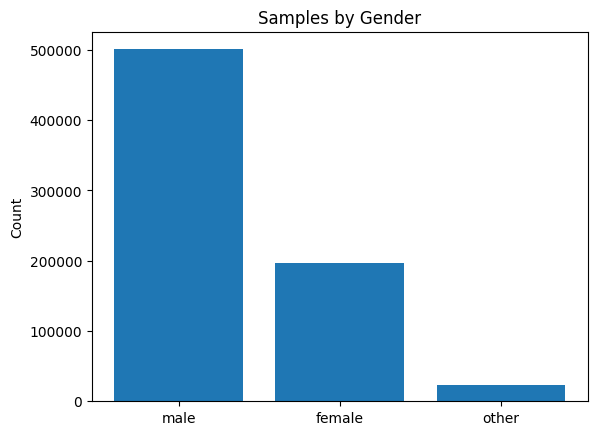

In [55]:
def samples_by_gender(df: pd.DataFrame) -> pd.Series:
    if df.empty:
        print("DataFrame is empty.")
        return pd.Series()

    gender_counts = df["gender"].dropna().value_counts()
    plt.bar(gender_counts.index, gender_counts.values)
    plt.title("Samples by Gender")
    plt.ylabel("Count")
    return gender_counts


gender_counts = samples_by_gender(df)
gender_counts

### Analysis
- The gender distribution shows a skew towards the **male** gender
- This imbalance may introduce bias if training a TTS model without correcting for it
- In future work, training data may need to be balanced to account for underrepresented gender categories

## Number of Samples by Accent
Calculate the number of samples by accent, sort it ascending number of samples, then plot the top 10 entries.

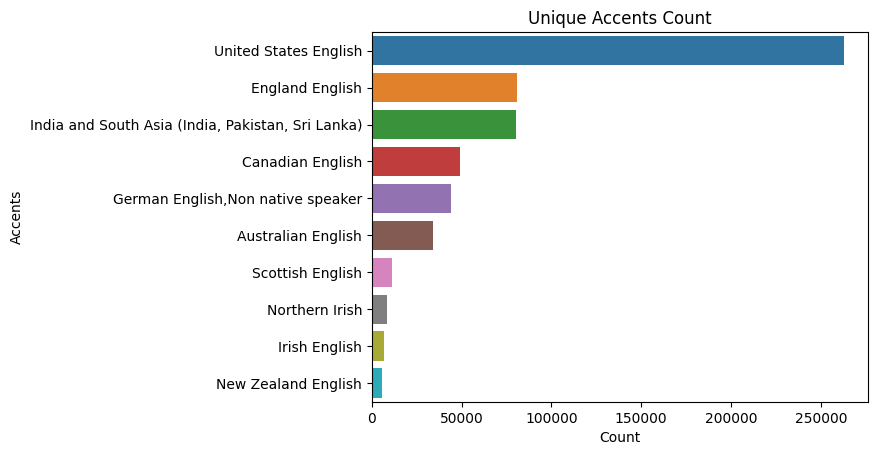

In [39]:
def samples_by_accent(df: pd.DataFrame):
    if df.empty:
        print("DataFrame is empty.")
        return df

    df = df.groupby("accents", dropna=True).size().reset_index()
    df.columns = ["accents", "count"]
    df = df.sort_values(by="count", ascending=False)
    df = df.iloc[0:10]
    sns.barplot(x="count", y="accents", data=df, palette="tab10", hue="accents")
    plt.title("Unique Accents Count")
    plt.xlabel("Count")
    plt.ylabel("Accents")


samples_by_accent(df)

## Dialect Distribution
Display a pie chart of the top 10 dialects in the `train.tsv` file.

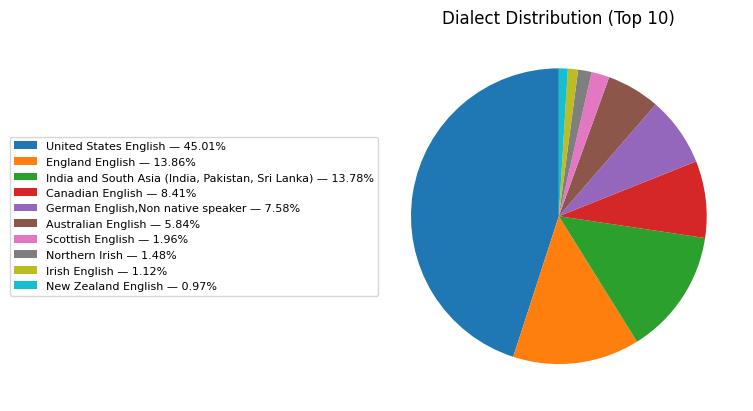

In [7]:
def dialect_distribution(df: pd.DataFrame):
    if df.empty:
        print("DataFrame is empty.")
        return

    top_accents = (
        df.groupby("accents", dropna=True)
        .size()
        .reset_index(name="count")
        .sort_values(by="count", ascending=False)
        .iloc[:10]
    )

    percents = 100.0 * top_accents["count"] / top_accents["count"].sum()

    colors, texts, *_ = plt.pie(top_accents["count"], startangle=90)
    labels = [
        "{0} — {1:1.2f}%".format(accent, count)
        for accent, count in zip(top_accents["accents"], percents)
    ]

    plt.legend(colors, labels, loc="center left", bbox_to_anchor=(-1, 0.5), fontsize=8)
    plt.title("Dialect Distribution (Top 10)")


dialect_distribution(df)

### Analysis
- The top 10 accents account for a **significant portion of the samples**, with the top 3 accents comprising **72.65%** of the samples
- Some dialect groups are overrepresented, while others appear underrepresented or missing
- In future work, data should be sampled evenly across dialects and documented with balancing strategies for a dialect-aware TTS model

## Number of Samples by Age Group
Display the samples by age group in a sorted count plot.

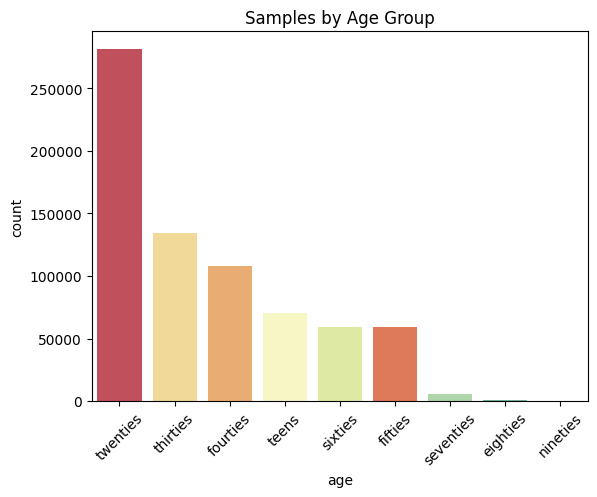

In [56]:
def samples_by_age_group(df: pd.DataFrame):
    if df.empty:
        print("DataFrame is empty.")
        return df

    samples_by_age_group = df["age"].dropna().value_counts()
    sns.countplot(
        x="age",
        data=df,
        order=samples_by_age_group.index,
        palette="Spectral",
        hue="age",
        legend=False,
    )
    plt.title("Samples by Age Group")
    plt.xticks(rotation=45)


samples_by_age_group(df)

### Analysis
- The data is heavily skewed towards the **twenties** age group
- There is a bias risk if age-related vocal characteristics are not balanced
- In future work, this may affect TTS voice diversity, particularly with underrepresented age groups

## Sentence Length Distribution
Display a histogram plot of the word length of the sentences in every entry by frequency, with outliers unused (>99.9% of sentences had sentence lengths<=15). Also display the mean length of a sentence spoken by an individual.

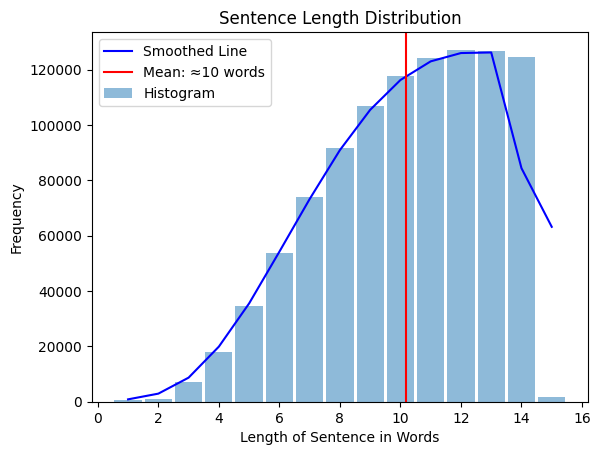

In [37]:
def sentence_length(df: pd.DataFrame):
    if df.empty:
        print("DataFrame is empty.")
        return df

    sentence_lengths = df["sentence"].apply(lambda x: len(x.split()))
    sentence_lengths = sentence_lengths[sentence_lengths < 16]
    counts = sentence_lengths.value_counts().sort_index()
    mean_length = sentence_lengths.mean()
    smoothed_counts = counts.rolling(window=3, center=True, min_periods=1).mean()
    plt.bar(counts.index, counts.values, width=0.9, alpha=0.5, label="Histogram")
    plt.plot(
        smoothed_counts.index, smoothed_counts.values, color="b", label="Smoothed Line"
    )
    plt.axvline(x=mean_length, color="r", label=f"Mean: ≈{round(mean_length)} words")
    plt.legend()
    plt.title("Sentence Length Distribution")
    plt.xlabel("Length of Sentence in Words")
    plt.ylabel("Frequency")


sentence_length(df)

### Analysis
- The majority of sentences are **short** with the sentence length being approximately **10 words** on average
- This reflects the nature of crowd-sourced speech data (short prompts, simple sentences)
- In future work, a TTS model trained on this data might struggle with **longer, natural sentences**

# Final Summary
- The Common Voice dataset is a valuable resource but comes with metadata sparsity and demographic imbalances
- Accent and gender distributions are skewed, which pose challenged for fair and accurate TTS modeling
- Sentence lengths are generally short, suggesting a need for diverse sentence structures in training data
- These insights highlight the importance of **data curation, preprocessing, and balancing** before model training

## Next Steps:
- Explore filtering strategies for underrepresented accents and accounting observed biases
- Analyze the audio recordings to assess quality and dialect authenticity
- Evaluate other datasets for training a dialect-aware TTS model